<a href="https://colab.research.google.com/github/athreyaanand/NeuralTransferPortraitAnimation/blob/master/portrait_animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Transfer Portrait Animation

This notebook should serve as an all-in-one tool to convert videos into style-transferred animations! 

The notebook works in the following order:

1.   User **uploads** video
2.   Video is **decomposed** into individual frames
3.   User **chooses series** of paintings/source images to base stylization
4.   Notebook automatically **partitions** video into equal-length sections
5.   A pre-trained stylization network **applies stylization** to each partition
6.   Stylized frames are **recomposed** and converted into an avi
7.   Notebook **converts** .avi to .mp4 and downloads file

The notebook should guide the user on what exactly to do for those not familiar with a colab environment and will try to make the process as easy as possible. If confusion arises, leave a comment on the cell (top right corner) and I'll add more clarification; now let's get to it!

*   Make sure you have changed the **frame rate** variable within the video decomposition section
*   Make sure you have added your **base photos** in the **Choose Images** section
*   To ensure a clean start go to **Runtime** -> **Factory Reset Runtime** -> **Yes**
 *  You might need to hit **connect/reconnect** on the top left
*   Go to **Runtime** -> **Change Runtime Type** -> **Hardware Accelerator** -> **GPU** -> **Save**
*   Go to **Runtime** -> **Run All**

## Video Upload

After running this cell, a little button should appear indicating for you to "choose files." This is where you upload your video file (mp4). You should be able to see the percentage completed under the dialog box and receive a confirmation message after completion.

In [0]:
from google.colab import files

print("**UPLOAD MP4 VIDEO FILE**\n")
uploaded = files.upload()

for file in uploaded.keys():
  print(f"{file} of size {len(uploaded[file])} successfully uploaded!")

IMPORT MP4 VIDEO FILE



Saving Guitar_Original_Video.mp4 to Guitar_Original_Video.mp4
User has uploaded video Guitar_Original_Video.mp4 of size 7868318


In [0]:
import os

filename = f"{os.getcwd()}/{list(uploaded.keys())[0]}"
dirname = os.path.splitext(filename)[0]

# creates a unique folder based off of the file name and enters it
if not os.path.exists(dirname):
  os.mkdir(dirname)
os.chdir(dirname)

## Video Decomposition

This section focuses on decomposing the video into individual frames. Make sure you change the **frame rate** below to whatever you wish!

In [0]:
import cv2

# creates a frames folder and enters it
if not os.path.exists(f"{dirname}/frames"):
  os.mkdir(f"{dirname}/frames")
os.chdir(f"{dirname}/frames")

# method to get frame from video
vidcap = cv2.VideoCapture(filename)
def get_frame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames, image = vidcap.read()
    if hasFrames:
        print(f"Writing frame {count}")
        cv2.imwrite("frame"+str(count)+".jpg", image) # saving frame as JPG file
    return hasFrames
    
sec = 0
'''
FRAME RATE

change the number dividing one into whatever frame rate you desire 
(i.e. 1/20 for 20 frames per second)
'''
frame_rate = 1/10 # <-- CHANGE HERE
count = 1
success = get_frame(sec)
while success:
    count = count + 1
    sec = sec + frame_rate
    sec = round(sec, 2)
    success = get_frame(sec)

Writing frame 1
Writing frame 2
Writing frame 3
Writing frame 4
Writing frame 5
Writing frame 6
Writing frame 7
Writing frame 8
Writing frame 9
Writing frame 10
Writing frame 11
Writing frame 12
Writing frame 13
Writing frame 14
Writing frame 15
Writing frame 16
Writing frame 17
Writing frame 18
Writing frame 19
Writing frame 20
Writing frame 21
Writing frame 22
Writing frame 23
Writing frame 24
Writing frame 25
Writing frame 26
Writing frame 27
Writing frame 28
Writing frame 29
Writing frame 30
Writing frame 31
Writing frame 32
Writing frame 33
Writing frame 34
Writing frame 35
Writing frame 36
Writing frame 37
Writing frame 38
Writing frame 39
Writing frame 40
Writing frame 41
Writing frame 42
Writing frame 43
Writing frame 44
Writing frame 45
Writing frame 46
Writing frame 47
Writing frame 48
Writing frame 49
Writing frame 50
Writing frame 51
Writing frame 52
Writing frame 53
Writing frame 54
Writing frame 55
Writing frame 56
Writing frame 57
Writing frame 58
Writing frame 59
Writin

## Style Transfer Individual Frames

### Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [0]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [0]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

### Choose Images

Below in the source_images variable, go ahead and add whatever paintings/images you wish to stylize off of. If you want more paintings, add a comma after the array entry and insert your other link. Ensure that there is atleast one source image or the program will fail!

In [0]:
'''
SOURCE IMAGES

- add your paintings below
- if you want to add an image, add a comma and insert your link in a new line

*- if you want one image throughout the entire image, only have one link
*- the more paintings, the shorter the respective sections so make sure you have a 
video long enough!
'''
source_images = ['https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
                 'https://upload.wikimedia.org/wikipedia/commons/a/a5/Tsunami_by_hokusai_19th_century.jpg'] # <-- ADD IMAGES HERE

image_count = 0
style_images = []
for source_image in source_images:
  style_images.append(load_img(tf.keras.utils.get_file(f'source_image{image_count}.jpg', source_image)))
  image_count += 1

2359296/2354187 [==============================] - 0s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


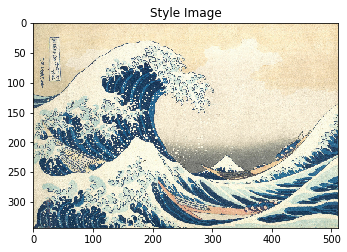

In [0]:
import re

# gets frames within folder and ensures that they are sorted
frames = [f for f in os.listdir(f"{dirname}/frames") if os.path.isfile(f)]
frames.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

# show first image in source_images
plt.subplot(1, 2, 2)
imshow(style_images[0], 'First Style Image')

In [0]:
# creates a stylized frames folder and enters it
if not os.path.exists(f"{dirname}/stylized_frames"):
  os.mkdir(f"{dirname}/stylized_frames")
os.chdir(f"{dirname}/stylized_frames")

### Stylization

In [0]:
import tensorflow_hub as hub

# load up pretrained network
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

# find frame partitions based off of # of paintings
frames_per_style = len(frames)//len(source_images)
# keep track of current frame count
stylized_frame_cnt = 0
# ptr to style_image within array
src_image_ptr = 0
for frame in frames:
  print(f"Stylizing {frame}")  
  stylized_image = hub_module(tf.constant(load_img(f"{dirname}/frames/{frame}")), tf.constant(style_images[src_image_ptr]))[0]
  tensor_to_image(stylized_image).save("stylized_" + frame)
  stylized_frame_cnt += 1
  # Go to next stylization and reset frame count
  if stylized_frame_cnt > frames_per_style and src_image_ptr < len(source_images) - 1:
    src_image_ptr += 1
    stylized_frame_cnt = 0

frames_per_style: 110
stylized_frame_cnt: 0
src_image_ptr: 0
Stylizing frame1.jpg
Stylizing frame2.jpg
Stylizing frame3.jpg
Stylizing frame4.jpg
Stylizing frame5.jpg
Stylizing frame6.jpg
Stylizing frame7.jpg
Stylizing frame8.jpg
Stylizing frame9.jpg
Stylizing frame10.jpg
Stylizing frame11.jpg
Stylizing frame12.jpg
Stylizing frame13.jpg
Stylizing frame14.jpg
Stylizing frame15.jpg
Stylizing frame16.jpg
Stylizing frame17.jpg
Stylizing frame18.jpg
Stylizing frame19.jpg
Stylizing frame20.jpg
Stylizing frame21.jpg
Stylizing frame22.jpg
Stylizing frame23.jpg
Stylizing frame24.jpg
Stylizing frame25.jpg
Stylizing frame26.jpg
Stylizing frame27.jpg
Stylizing frame28.jpg
Stylizing frame29.jpg
Stylizing frame30.jpg
Stylizing frame31.jpg
Stylizing frame32.jpg
Stylizing frame33.jpg
Stylizing frame34.jpg
Stylizing frame35.jpg
Stylizing frame36.jpg
Stylizing frame37.jpg
Stylizing frame38.jpg
Stylizing frame39.jpg
Stylizing frame40.jpg
Stylizing frame41.jpg
Stylizing frame42.jpg
Stylizing frame43.jpg
St

## Video Recomposition

In [0]:
image_folder = f"{dirname}/stylized_frames"
video_name = f"{dirname}/PORTRAIT.avi"

# obtain all stylized frames and ensure they are in order
stylized_frames = [f for f in os.listdir(image_folder) if os.path.isfile(f)]
stylized_frames.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

frame = cv2.imread(os.path.join(image_folder, stylized_frames[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1/frame_rate, (width,height))

# combine ordered frames into single video
for stylized_frame in stylized_frames:
  print(f"adding {stylized_frame} to {video_name}...")
  video.write(cv2.imread(os.path.join(image_folder, stylized_frame)))

cv2.destroyAllWindows()
video.release()
print("DONE!")

['stylized_frame1.jpg', 'stylized_frame2.jpg', 'stylized_frame3.jpg', 'stylized_frame4.jpg', 'stylized_frame5.jpg', 'stylized_frame6.jpg', 'stylized_frame7.jpg', 'stylized_frame8.jpg', 'stylized_frame9.jpg', 'stylized_frame10.jpg', 'stylized_frame11.jpg', 'stylized_frame12.jpg', 'stylized_frame13.jpg', 'stylized_frame14.jpg', 'stylized_frame15.jpg', 'stylized_frame16.jpg', 'stylized_frame17.jpg', 'stylized_frame18.jpg', 'stylized_frame19.jpg', 'stylized_frame20.jpg', 'stylized_frame21.jpg', 'stylized_frame22.jpg', 'stylized_frame23.jpg', 'stylized_frame24.jpg', 'stylized_frame25.jpg', 'stylized_frame26.jpg', 'stylized_frame27.jpg', 'stylized_frame28.jpg', 'stylized_frame29.jpg', 'stylized_frame30.jpg', 'stylized_frame31.jpg', 'stylized_frame32.jpg', 'stylized_frame33.jpg', 'stylized_frame34.jpg', 'stylized_frame35.jpg', 'stylized_frame36.jpg', 'stylized_frame37.jpg', 'stylized_frame38.jpg', 'stylized_frame39.jpg', 'stylized_frame40.jpg', 'stylized_frame41.jpg', 'stylized_frame42.jpg', 

## Conversion and Final Download

In [0]:
output = f"{dirname}/animated_portrait.mp4"

# converting avi to mp4
os.popen(f"ffmpeg -i '{video_name}' -ac 2 -b:v 2000k -c:a aac -c:v libx264 -b:a 160k -vprofile high -bf 0 -strict experimental -f mp4 '{output}'")
print("Preparing download...")
files.download(output)
print("ENJOY!")